# Group information

Names: Andreas Cisi Ramos e João Pedro de Moraes Novaes


RAs: 246932 e 174494

## Objective:

To explore **Transfer Learning** techniques, focused on **Transformers**. In this task you'll be visualizing and fine tunning a pre trained transformer to a Natural Language Processing task, specifically, binary sentiment classification.

This **MUST** be developed using the pytorch and the [Hugging Face](https://huggingface.co/) library.

## Dataset

The dataset you will use is the "Large Movie Review Dataset", also known as IMDB dataset. This dataset contains 50000 movie reviews, with positive or negative labels. The dataset is balanced, and the train and test sets are already separated in a disjointed way, to avoid movies being in both datasets (as reviews in the same movies tend to be similar).

The labels are constructed using the ratings of the review, where a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. "Neutral" reviews (score 5 or 6) were ignored, as they cannot be correctly labeled between negative and positive samples.


The dataset will be available in the [same folder](https://drive.google.com/drive/folders/14uiy_7xMq5LOqODBzbIJLD4Vq0E9XD5v) as the other tasks, in the "aclImdb" folder. You can copy the dataset folder or download it locally.

Here are some examples of each class from the dataset:

**Negative**

`Lifetime did it again. Can we say stupid? I couldn't wait for it to end. The plot was senseless. The acting was terrible! Especially by the teenagers. The story has been played a thousand times! Are we just desperate to give actors a job? The previews were attractive and I was really looking for a good thriller.Once in awhile lifetime comes up with a good movie, this isn't one of them. Unless one has nothing else to do I would avoid this one at all cost. This was a waste of two hours of my life. Can I get them back? I would have rather scraped my face against a brick wall for two hours then soaked it in peroxide. That would have been more entertaining.`

**Positive**

`Generally it was a good movie with an ideal ending; the acting was spectacular and the characters didn't stray from their persons. I especially liked the plot, although you knew what was going to happen it still gave the element of surprise through out the entire movie. However, I find that coming on to the ending it could have been a little longer (extended maybe)- to me it seemed like it was rushed a bit; as if the writer was trying to take linens off the lines before the rain fell. For instance- What happened to Tristan's brother, Hayden? For all we know he died in the hospital. Maybe he was the one that setup the entire thing?! Who knows! Maybe there will be a sequel? Maybe? If there is.. I cant wait to see it.`


As in the previous task, in this task the data analysis will not be required. Again, its important to remember that the data analysis is a constant and important part of the machine learning pipeline, and we are just skipping it because this task has educational purposes only.

## Loading the dataset

The code below is already completed to load the dataset separating it in train, validation and test.

In [6]:
import os
import random
import pandas as pd

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from transformers import BertTokenizerFast, BertForSequenceClassification

In [7]:
# Define dataset path (remove colab import/mount if running locally)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# set path to the folder that contains the aclImdb dataset
path = "gdrive/MyDrive/SEMESTRES/7° Semestre (2024)/MC886/"

Mounted at /content/gdrive


In [8]:
# this separates 20k for training, 5k for validation and 25k for testing

max_valid = 5000

def load_texts(folder):
  texts = []
  for path in os.listdir(folder):
    with open(os.path.join(folder, path)) as f:
      texts.append(f.read())
  return texts

x_train_pos = load_texts(path + 'aclImdb/train/pos')
x_train_neg = load_texts(path + 'aclImdb/train/neg')
x_test_pos  = load_texts(path + 'aclImdb/test/pos')
x_test_neg  = load_texts(path + 'aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test  = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test  = [True] * len(x_test_pos)  + [False] * len(x_test_neg)

c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print('\nFirst two train samples:')
for i, (source, target) in enumerate(zip(x_train[:2], y_train[:2])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print('\nFirst two valid samples:')
for i, (source, target) in enumerate(zip(x_valid[:2], y_valid[:2])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print(f'Train size: {len(x_train)}')
print(f'Valid size: {len(x_valid)}')
print(f'Test size: {len(x_test)}')


First two train samples:
0: Input: Maybe it's the dubbing, or maybe it's the endless scenes of people crying, moaning or otherwise carrying on, but I found Europa '51 to be one of the most overwrought (and therefore annoying) films I've ever seen. The film starts out promisingly if familiarly, as mom Ingrid Bergman is too busy to spend time with her spoiled brat of a son (Sandro Franchina). Whilst mummy and daddy (bland Alexander Knox) entertain their guests at a dinner party, the youngster tries to kill himself, setting in motion a life changing series of events that find Bergman spending time showering compassion on the poor and needy. Spurred on by Communist newspaper editor Andrea (Ettore Giannini), she soon spends more time with the downtrodden than she does with her husband, who soon locks her up in an insane asylum for her troubles. Bergman plays the saint role to the hilt, echoing her 1948 role as Joan of Arc, and Rossellini does a fantastic job of lighting and filming her to 

## Loading the pre trained transformer

The code below loads a pre trained transformer from hugging face library.
The **recommended** model is the BERT-Mini, that is a smaller version of the BERT transformer.

You can choose other transformers to test, but the BERT-Mini was choosed to reduce the fine tunning time, while also having a powerfull structure.

The image below shows the normal BERT architecture scheme and the BERT-Large. In the same way, the BERT-Mini has only four attention heads (instead of the original 12).

![BERTS](https://huggingface.co/blog/assets/52_bert_101/BERT-size-and-architecture.png)

The BERT variations also are related to amount of hidden embedding sizes.
Some variations are:

- google/bert_uncased_L-2_H-128_A-2 (BERT-Tiny, 4M params)
- google/bert_uncased_L-4_H-256_A-4 (BERT-Mini, 11M params)
- google/bert_uncased_L-4_H-512_A-4 (BERT-Small, 29M params)
- google/bert_uncased_L-8_H-512_A-8 (BERT-Medium, 41M params)
- google/bert_uncased_L-12_H-768_A-12 (BERT-Base, 110M params)

You can find more details about miniature BERT versions [here](https://huggingface.co/google/bert_uncased_L-4_H-256_A-4).


## Parameters

Utilizaremos 5 épocas para conseguir aproveitar melhor os limites do Colab


In [9]:
params = {
    'bert_version': "google/bert_uncased_L-4_H-256_A-4",
    'batch_size': 64,
    'learning_rate': 1e-4, # Choose a learning rate between 1e-4 and 1e-7
    'weight_decay': 0.01,  # Choose a value between 1e-2 and 1e-4.
    'max_length': 100,     # The maximum length of the sentence (can be adjusted)
    'epochs': 5,           # Choose a value between 1 and 5
}

## Tokenizer

To use text as input for a deep learning model, we first need to tokenize each sentence based on a set of rules. After tokenization, each token is assigned a correlated index, creating a feature vector. This vector is then utilized by the model to train and update the weights. Here is an example demonstrating how the BERT tokenizer works:

![bert_tokenizer](https://drive.google.com/uc?export=view&id=11LioDFis0JE3ghr672PEIeaAxZO42gUL)

Initially, the input sentence is divided into tokens predetermined by the BERT tokenizer. Next, the BertTokenizer introduces two special tokens: CLS and SEP. CLS represents sentence start for tasks like classification, while SEP indicates sentence separation for boundary detection within a document. Additionally, to ensure sentences are of equal length, the tokenizer employ the PAD token for each input.

Finally, each token is converted into a predetermined index for BERT input. This indexing enables the Bert model to train and update its weights effectively.

In [10]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data   = data
        self.labels = torch.Tensor(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.data.items()}
        item['labels'] = self.labels[index]
        return item

In [11]:
tokenizer = BertTokenizerFast.from_pretrained(params['bert_version'], disable_tqdm=False)

## TOKENIZE
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encodings = tokenizer(list(x_valid), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
test_encodings  = tokenizer(list(x_test),  truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

## DATASET
train_dataset = IMDBDataset(data=train_encodings, labels=y_train)
valid_dataset = IMDBDataset(data=valid_encodings, labels=y_valid)
test_dataset  = IMDBDataset(data=test_encodings, labels=y_test)

## DATALOADER
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=1)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params['batch_size'], num_workers=1)
test_loader  = DataLoader(dataset=test_dataset, batch_size=params['batch_size'], num_workers=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

## Load the transformer


In [12]:

#defining device where to to the computation
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(params['bert_version'])
model = model.to(device)


pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dimentionality reduction and visualization tranformer embeddings (3.5 points)

In this section, you should use PCA and t-SNE to visualize the embeddings produced by the transformer for a batch of the aclImdb dataset.

In [13]:
# Function to visualize the embeddings

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_layerwise_embeddings(hidden_states, masks, labels, layers_to_visualize, dim_reducer):
  '''
  'hidden_states' are the activations of the hidden layers for a batch
    (use the '.hidden_states' attribute from the transformer's output with 'output_hidden_states=True');
  'masks' are the attention masks of each sample (the dataloader returns a dict with the "attention_masks" key);
  'labels' are the labels of the batch;
  'layers_to_visualize' is an array of indexes to look on 'hidden_states';
  'dim_reducer' is a function to reduce the dimentionality of the hidden states (should be PCA or t-SNE object).
  '''
  num_layers = len(layers_to_visualize)

  fig = plt.figure(figsize=(24,int((num_layers/4)*6))) # each subplot of size 6x6, each row will hold 4 plots
  ax = [fig.add_subplot(num_layers//4+1,4,i+1) for i in range(num_layers)]

  labels = labels.numpy().reshape(-1)

  for i,layer_i in enumerate(layers_to_visualize):
    layer_embeds = hidden_states[layer_i].cpu()

    layer_averaged_hidden_states = torch.div(layer_embeds.sum(dim=1),masks.sum(dim=1,keepdim=True))
    layer_dim_reduced_embeds = dim_reducer.fit_transform(layer_averaged_hidden_states.detach().numpy())

    df = pd.DataFrame.from_dict({'x':layer_dim_reduced_embeds[:,0],'y':layer_dim_reduced_embeds[:,1],'label':labels})

    sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i], palette='husl')

## Preparação

Primeiramente precisamos dessa parte do código para extrair os estados ocultos intermediários de um modelo transformer durante a fase de avaliação.

O método get_hidden_states coleta os estados ocultos do modelo para cada lote de dados, movendo os tensores para o dispositivo especificado (CPU ou GPU). Este processo é essencial para analisar e interpretar como o modelo representa as entradas em diferentes camadas, facilitando a visualização dos padrões aprendidos pelo modelo durante o treinamento.

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_hidden_states(model, dataloader, device):

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states

            return hidden_states, attention_mask, labels

## Redução de Dimensionalidade e Plot dos Gráficos

Essa parte do código realiza a extração dos estados ocultos do modelo usando o train_loader e a função get_hidden_states.

Utilizamos PCA e t-SNE para reduzir a dimensionalidade dos estados ocultos a duas dimensões, permitindo a visualização.

A função visualize_layerwise_embeddings é chamada duas vezes, uma para cada técnica de redução de dimensionalidade, facilitando a comparação das representações das camadas do modelo.

Abaixo representa os gráficos plotados com 5 épocas para o PCA e outras 5 para o t-SNE.

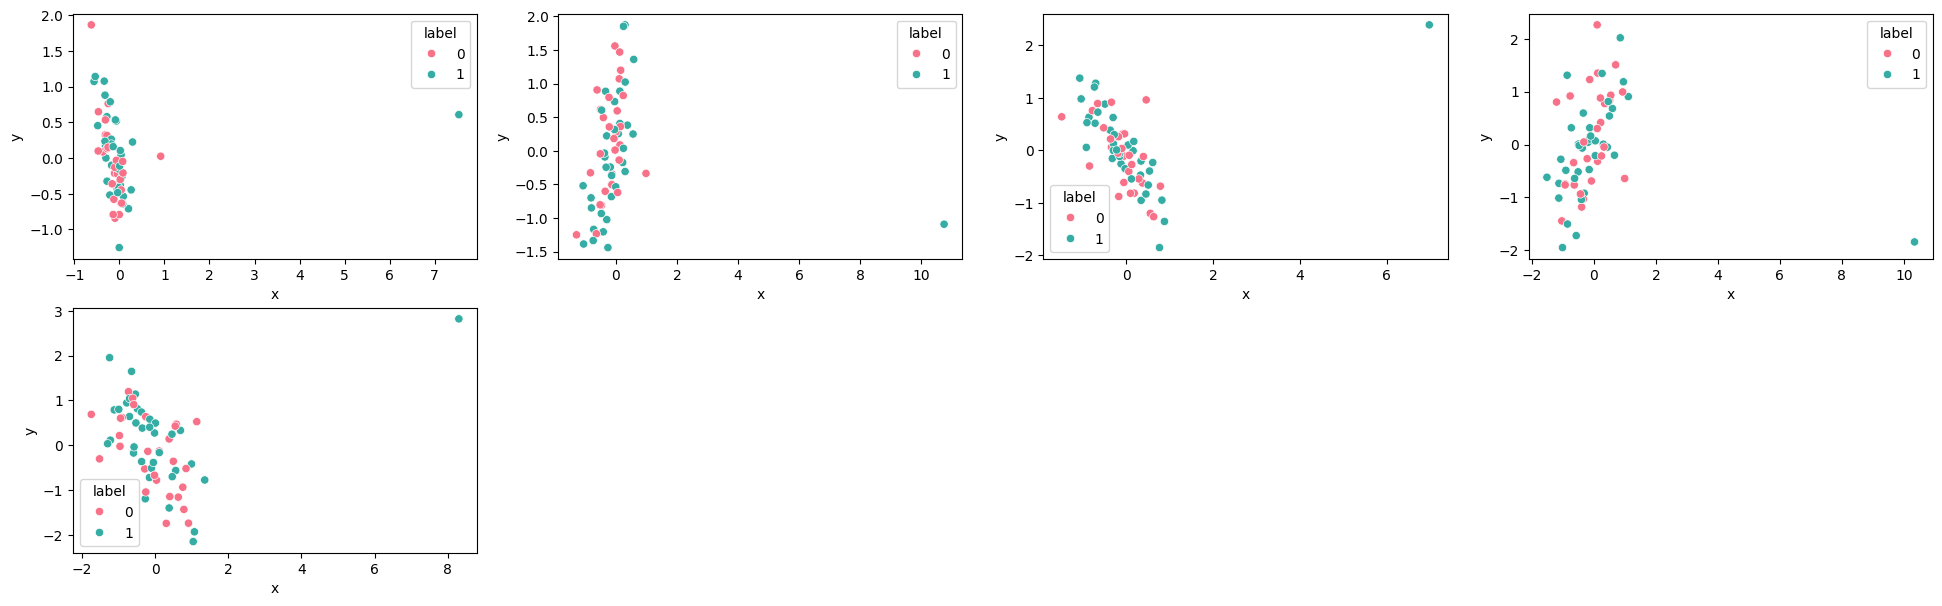

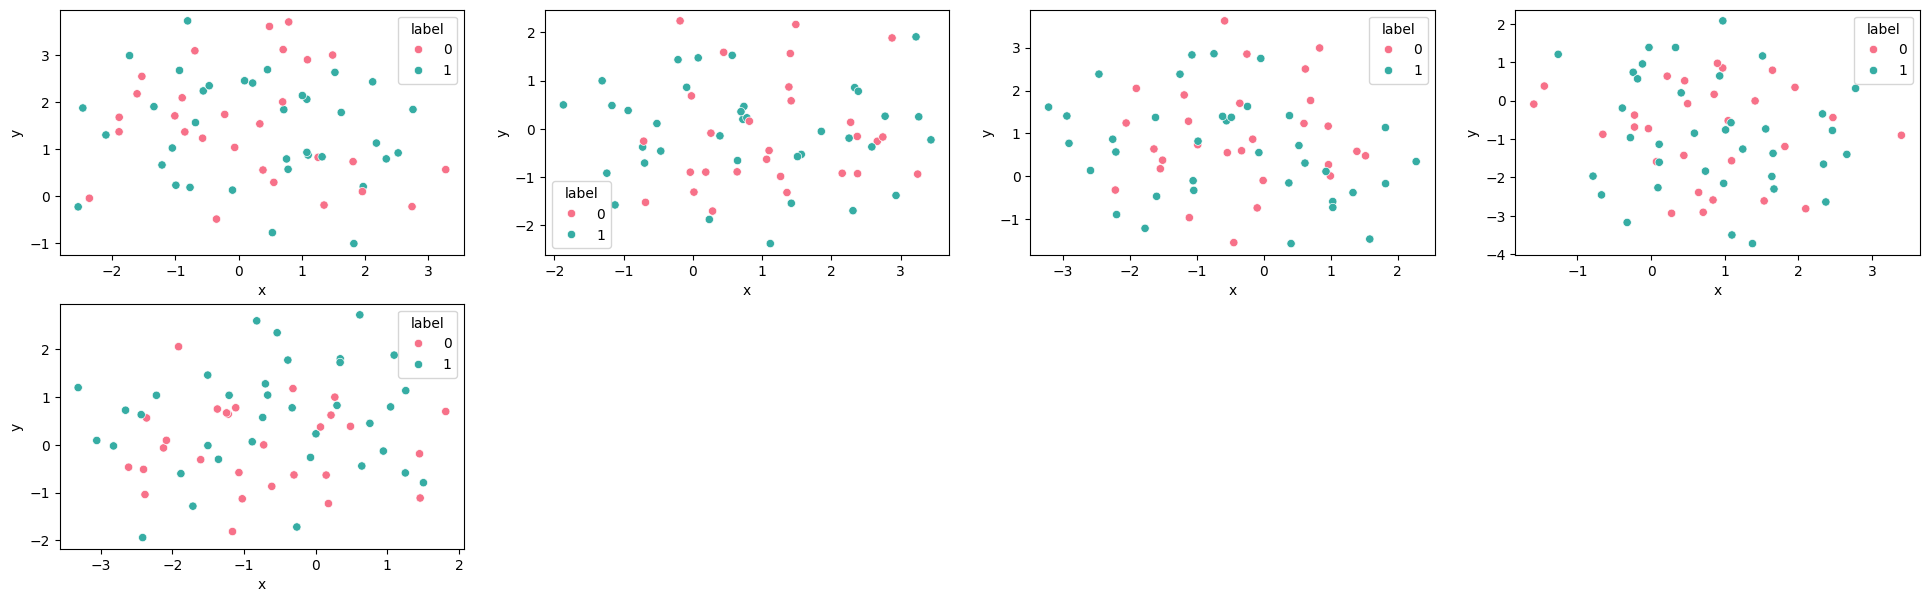

In [15]:
# Batch do Dataloader
hidden_states, attention_mask, labels = get_hidden_states(model, train_loader, device)

#Mover todos os tensores para a CPU
hidden_states = [layer.cpu() for layer in hidden_states]
labels = labels.cpu()
attention_mask = attention_mask.cpu()

# Numero de Layers no Modelo
model_layers = model.config.num_hidden_layers + 1
layers_to_visualize = [i for i in range(model_layers)]

# PCA
pca = PCA(n_components=2)
visualize_layerwise_embeddings(hidden_states, attention_mask, labels, layers_to_visualize, pca)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
visualize_layerwise_embeddings(hidden_states, attention_mask, labels, layers_to_visualize, tsne)

### Discussion of key points

- The PCA and t-SNE had similar results for the visualization of the embeddings?
- Looking at the best result, this transformer can be used as a Zero-shot* model for this task?


* Zero-shot is the usage a model for a new task without any new traning.

**1. The PCA and t-SNE had similar results for the visualization of the embeddings?**

As representações PCA apresentam uma distribuição onde os pontos de diferentes classes (labels) estão misturados, sem uma clara separação entre as classes.

Os gráficos t-SNE também mostram uma mistura de classes, mas em algumas camadas, há uma melhor separação entre as classes 0 e 1 em comparação com o PCA. O t-SNE tende a capturar a estrutura local dos dados, resultando em uma visualização mais clara das diferenças entre as classes.

 Embora ambas as técnicas mostrem uma mistura de classes, o t-SNE parece
 mostrar uma separação melhor entre as classes em algumas camadas. No entanto, a diferença não é extremamente significativa, e ambas as técnicas indicam que os embeddings ainda apresentam um certo grau de mistura entre as classes.

**2. Looking at the best result, this transformer can be used as a Zero-shot model for this task?**
Discussion:

Baseando-se nos gráficos, o modelo transformer não mostra uma clara separação entre as classes nos embeddings finais. Para um modelo ser eficaz em um cenário Zero-shot, seria esperado que ele exibisse uma separação clara e distintiva entre as classes sem treinamento adicional. A mistura observada nas visualizações sugere que o modelo não está distinguindo suficientemente bem entre as classes apenas com o pré-treinamento.

Portanto, com base nos resultados visuais, este transformer não parece ser adequado como um modelo Zero-shot para a tarefa de classificação de sentimentos, uma vez que os embeddings não mostram uma separação clara entre as classes.

## Fine tune the transformer (5.5 points)

In this section you should fine tune the transformer for the sentiment classification task.

To fine tune a model, we need to "freeze" some of their layers. In this case, we will freeze all trainable parameters, except the last part of the model, which is a fully connected layer called "classifier". You can change this approach and test without freezing the entire transformer, but it is not required.

It is important to pay attention to the learning rate and weight decay of the optimizer. Usually, transformers adapt quickly to the problem, and a wrong learning rate (or number of training epochs) can cause an overfitting.

Work with one epoch and smaller batch sizes to test your implementation, as the training can take a longe time.

Remember to test your final model and plot a confusion matrix with the test data.


In [16]:
# Freeze all layers of the pre trained model
for i,param in enumerate(model.parameters()):
  param.requires_grad = False

# unfreeze classifier (last layer)
model.classifier.weight.requires_grad = True

In [17]:
# Define the optmizer, scheduler and criterion

optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay']) # https://pytorch.org/docs/stable/optim.html
# scheduler = # Optional: use a scheduler to control the learning rate (besides the weight_decay of the optimizer)
criterion = torch.nn.CrossEntropyLoss()


### Create the train and validation logic

*Tip: The forward method of the BERT transformer expect the "input_ids" and "attention_masks". You can search about the usage of hugging face transformers on the official documentation [here](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/bert#transformers.BertForSequenceClassification)*

## Treinando o Modelo

Para entender melhor o que o treinamento do modelo pesquisamos e montamos o algoritmo descrito abaixo.

A função começa configurando o modelo no modo de treinamento e inicializa variáveis para rastrear a perda total e a contagem de acertos .

Para cada batch de dados no train_loader, os tensores de entrada, máscara de atenção e rótulos são movidos para o dispositivo apropriado (GPU ou CPU).

O otimizador é reinicializado e, em seguida, é realizada a passagem para frente do modelo, calculando a perda e os logits (saídas do modelo).
A perda é então retropropagada e os parâmetros do modelo são atualizados .

A perda total e o número de acertos são acumulados para todos os lotes. Finalmente, a função calcula a perda média de treinamento  e a precisão média de treinamento antes de retorná-las.








In [18]:
def train():
    model.train()
    total_loss, total_correct = 0, 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / len(train_loader.dataset)
    return train_loss, train_acc


## Avaliando o Modelo

Esta parte do código define a função avalia o desempenho do modelo transformer em um conjunto de dados de validação.

A função começa configurando o modelo no modo de avaliação  e inicializa variáveis para rastrear a perda total e a contagem de acertos, assim como no treino.

Com a avaliação configurada para não calcular gradientes a função itera sobre cada batch de dados no valid_loader, movendo os tensores de entrada, máscara de atenção e rótulos para o dispositivo apropriado (GPU ou CPU).

O modelo faz a Foward Pass, calculando a perda e os logits (saídas do modelo). A perda total e o número de acertos são acumulados para todos os batches.

Finalmente, a função calcula a perda média de validação e a precisão média de validação antes de retorná-las.

In [19]:
def evaluate():
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            total_correct += (logits.argmax(dim=1) == labels).sum().item()

    valid_loss = total_loss / len(valid_loader)
    valid_acc = total_correct / len(valid_loader.dataset)
    return valid_loss, valid_acc


### Train and validate

In [20]:
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

for epoch in tqdm(range(params['epochs']), desc='Training'):
    train_loss, train_acc = train()
    valid_loss, valid_acc = evaluate()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)

    print(f"Epoch {epoch+1}/{params['epochs']}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.6813, Train Acc: 0.5696, Valid Loss: 0.6632, Valid Acc: 0.6610
Epoch 2/5, Train Loss: 0.6645, Train Acc: 0.6184, Valid Loss: 0.6491, Valid Acc: 0.6570
Epoch 3/5, Train Loss: 0.6540, Train Acc: 0.6280, Valid Loss: 0.6375, Valid Acc: 0.6648
Epoch 4/5, Train Loss: 0.6460, Train Acc: 0.6390, Valid Loss: 0.6287, Valid Acc: 0.6738
Epoch 5/5, Train Loss: 0.6411, Train Acc: 0.6409, Valid Loss: 0.6227, Valid Acc: 0.6764


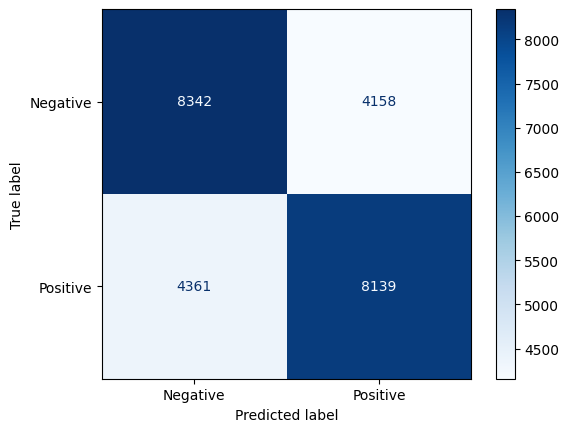

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = logits.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Calculando a Confussion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


## Visualize transformer embeddings again (1 point)

Use the same logic previously used in the first part of this task to visualize the fine tunned embeddings of the transformer (with PCA and t-SNE).

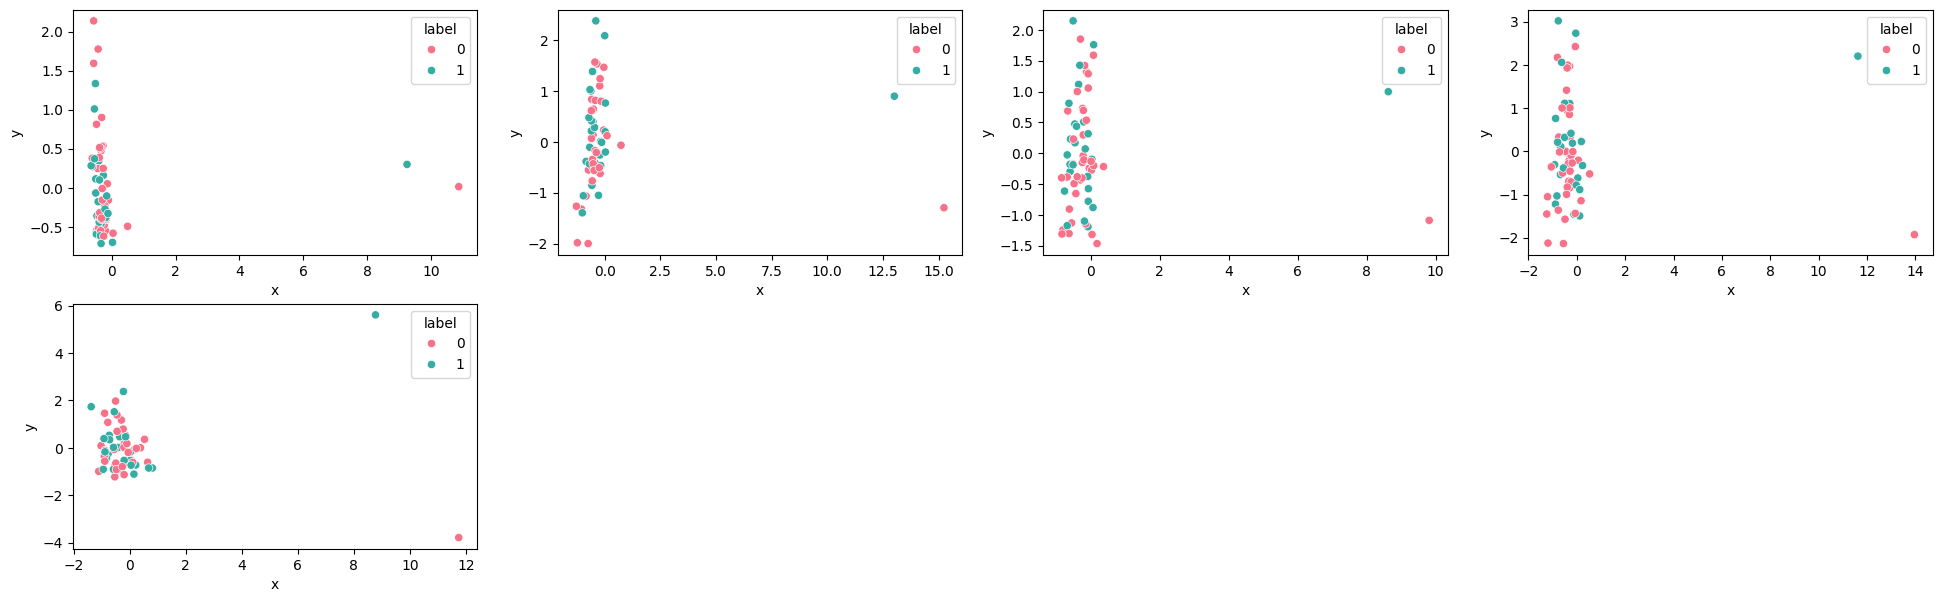

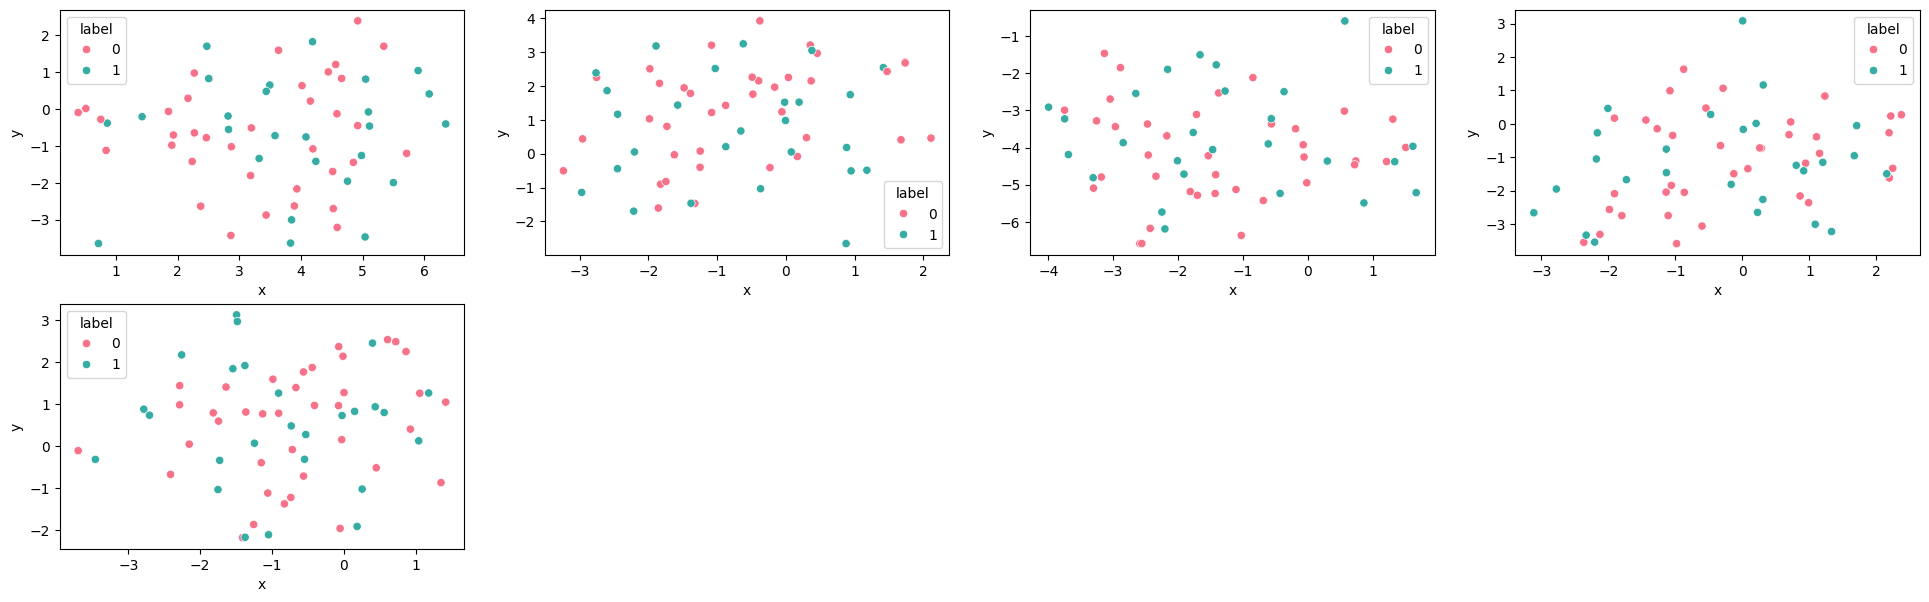

In [22]:
# Batch do Dataloader
hidden_states, attention_mask, labels = get_hidden_states(model, train_loader, device)

#Mover todos os tensores para a CPU
hidden_states = [layer.cpu() for layer in hidden_states]
labels = labels.cpu()
attention_mask = attention_mask.cpu()

# Numero de Layers no Modelo
model_layers = model.config.num_hidden_layers + 1
layers_to_visualize = [i for i in range(model_layers)]

# PCA
pca = PCA(n_components=2)
visualize_layerwise_embeddings(hidden_states, attention_mask, labels, layers_to_visualize, pca)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
visualize_layerwise_embeddings(hidden_states, attention_mask, labels, layers_to_visualize, tsne)

### Discussion of key points

- The fine tunning was able to improve the embedding visualization?


**The fine tunning was able to improve the embedding visualization?**

Os gráficos antes do treinamento mostram pontos dispersos e sem uma separação clara entre classes, enquanto os gráficos após o treinamento exibem uma estrutura um pouco melhor , mas ainda uma separação entre as classes bem caótica, indicando que o modelo teve dificuldades em aprender e distinguir os padrões nos dados.

## Deadline

Friday, June 28, 11:59 pm.

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- June 29, 11:59 pm : grade * 0.75
- June 30, 11:59 pm : grade * 0.5
- July 01, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English) or Google Colaboratory link (remember to share it!).

**This activity is NOT individual, it must be done in pairs (two-person group).**

Only one individual should deliver the notebook.